<a href="https://colab.research.google.com/github/hnuwong/ASL_study_2021/blob/main/ASL_task_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 과제 2. 

## 1) Fashion MNIST (or CIFAR10)를 분류하는 CNN 학습하기

CNN이 image data에서 DNN에 비해 얼마나 뛰어난지를 확인하는 것이 목표입니다. 모수의 수가 비슷한 DNN과 CNN을 구축한 뒤 데이터를 이용하여 각각의 모형을 학습하고
test accuracy를 비교합니다.


## 2) 전이학습 활용해보기.

전이학습을 실제로 활용해보는 것을 목표로 합니다.
GoogLenet을 이용하여 CIFAR10의 feature vector를 구축하고 이 feature vector를 이용하여 multi-class logistic regression model을 학습합니다.
이 모형의 결과를 앞서 CNN으로 학습한 모형의 결과와 비교해봅니다.

## CIFAR10을 분류하는 CNN 학습하기

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, models
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.utils import plot_model

import keras
from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3, preprocess_input

import numpy as np

print(tf.__version__)

2.6.0


In [ ]:
## load cifar data
(train_x, train_y), (test_x, test_y) = cifar10.load_data()
print(train_y.shape)
train_y = np.squeeze(train_y)
print(train_y.shape)

170508288/170498071 [==============================] - 2s 0us/step
(50000, 1)
(50000,)


(50000, 75, 75, 3)


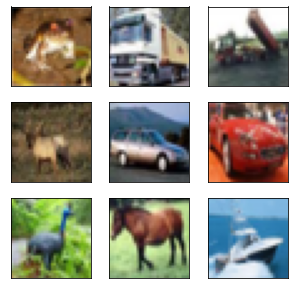

(10000, 75, 75, 3)


0

In [ ]:
import gc
import matplotlib.pyplot as plt

## resize the cifar data from 32*32*3 rto 75*75*3
train_images = tf.constant(train_x, dtype=tf.float32)
train_x = tf.image.resize(train_images, [75,75]).numpy()
print(train_x.shape)

## plot images
plt.figure(figsize=(5,5))
for coll in range(9):
  plt.subplot(3,3,coll+1)
  plt.imshow(train_images[coll]/255.)
  plt.xticks([])
  plt.yticks([])
plt.show()

del train_images ## delete the redundant variables
gc.collect()              ## free memory

test_images = tf.constant(test_x, dtype=tf.float32)
test_x = tf.image.resize(test_images, [75,75]).numpy()
print(test_x.shape)
del test_images   ## delete the redundant variables
gc.collect()              ## free memory

In [ ]:
## pre-process train and test data
train_x = preprocess_input(train_x)
test_x = preprocess_input(test_x)
print(train_x.shape)
print(train_x[0])

(50000, 75, 75, 3)
[[[-0.5372549  -0.5137255  -0.5058824 ]
  [-0.5548235  -0.5312941  -0.52564704]
  [-0.608366   -0.5848366  -0.58588237]
  ...
  [ 0.17856205 -0.02300656 -0.19660127]
  [ 0.16517651 -0.02635294 -0.19325489]
  [ 0.16078436 -0.02745098 -0.19215685]]

 [[-0.5844706  -0.5598432  -0.5530981 ]
  [-0.6020392  -0.57802665 -0.5731702 ]
  [-0.6555817  -0.6334431  -0.6343425 ]
  ...
  [ 0.14565754 -0.0667451  -0.25084442]
  [ 0.13555133 -0.06774902 -0.24468708]
  [ 0.13223529 -0.06807846 -0.24266666]]

 [[-0.728366   -0.7003922  -0.69699347]
  [-0.74593467 -0.7204497  -0.7180026 ]
  [-0.7994771  -0.78157735 -0.7820305 ]
  ...
  [ 0.0453769  -0.20004356 -0.41615683]
  [ 0.04526532 -0.19390851 -0.40143263]
  [ 0.04522872 -0.19189543 -0.39660132]]

 ...

 [[ 0.40156865  0.10718954 -0.17908484]
  [ 0.39293075  0.09009671 -0.22315276]
  [ 0.36660564  0.0380044  -0.35745507]
  ...
  [-0.12388647 -0.37902373 -0.5810716 ]
  [-0.19103765 -0.4337932  -0.59847295]
  [-0.21307158 -0.4517644

In [ ]:
## Define a DNN model and CNN model
## set the number of params. of DNN and the number of params. of CNN to be similar

## DNN model
dnn_model = models.Sequential ([
  Flatten(input_shape=(75,75,3)),
  Dense(110, activation='relu'),
  Dense(100, activation='relu'),
  Dense(10, activation='softmax')
])

## CNN model
cnn_model = models.Sequential([
  Conv2D(32, (3,3), activation='relu', input_shape=(75,75,3)),
  MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid'),
  Conv2D(64, (3,3), activation='relu'),
  MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid'),
  Flatten(),
  Dense(64, activation='relu'),
  Dense(10, activation='softmax')
])

dnn_model.summary()
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 16875)             0         
_________________________________________________________________
dense (Dense)                (None, 110)               1856360   
_________________________________________________________________
dense_1 (Dense)              (None, 100)               11100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 1,868,470
Trainable params: 1,868,470
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 32)        896       
________________________

In [ ]:
dnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

dnn_hist=dnn_model.fit(train_x, train_y, epochs=20, batch_size=100, validation_split=0.10)
cnn_hist=cnn_model.fit(train_x, train_y, epochs=20, batch_size=100, validation_split=0.10)

Epoch 1/20
450/450 [==============================] - 14s 30ms/step - loss: 1.9975 - accuracy: 0.3509 - val_loss: 1.7286 - val_accuracy: 0.3968
Epoch 2/20
450/450 [==============================] - 13s 30ms/step - loss: 1.6309 - accuracy: 0.4303 - val_loss: 1.5967 - val_accuracy: 0.4408
Epoch 3/20
450/450 [==============================] - 13s 29ms/step - loss: 1.5033 - accuracy: 0.4679 - val_loss: 1.5411 - val_accuracy: 0.4694
Epoch 4/20
450/450 [==============================] - 13s 30ms/step - loss: 1.4238 - accuracy: 0.4981 - val_loss: 1.4988 - val_accuracy: 0.4744
Epoch 5/20
450/450 [==============================] - 14s 30ms/step - loss: 1.3641 - accuracy: 0.5200 - val_loss: 1.4745 - val_accuracy: 0.4948
Epoch 6/20
450/450 [==============================] - 13s 30ms/step - loss: 1.3233 - accuracy: 0.5322 - val_loss: 1.4605 - val_accuracy: 0.4974
Epoch 7/20
450/450 [==============================] - 14s 30ms/step - loss: 1.2824 - accuracy: 0.5483 - val_loss: 1.4643 - val_accuracy:

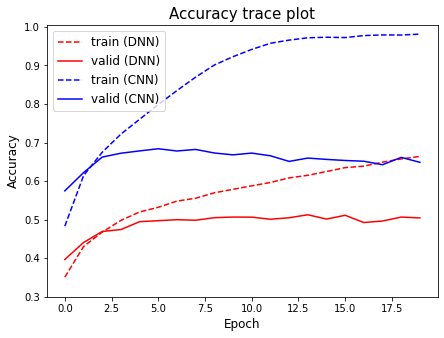

313/313 [==============================] - 19s 61ms/step - loss: 3.0007 - accuracy: 0.6359
Performance of DNN
...test accuracy: 0.506, test loss: 1.589
Performance of CNN
...test accuracy: 0.636, test loss: 3.001


In [ ]:
plt.figure(figsize=(7,5))
plt.plot(dnn_hist.history['accuracy'], 'r--', label='train (DNN)')
plt.plot(dnn_hist.history['val_accuracy'], 'r-', label='valid (DNN)')
plt.plot(cnn_hist.history['accuracy'], 'b--', label='train (CNN)')
plt.plot(cnn_hist.history['val_accuracy'], 'b-', label='valid (CNN)')
plt.ylim([0.3,1.005])
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.title('Accuracy trace plot', fontsize=15)
plt.show()

dnn_sc = dnn_model.evaluate(test_x, test_y)
cnn_sc = cnn_model.evaluate(test_x, test_y)
print('Performance of DNN')
print('...test accuracy: %.3f, test loss: %.3f'%(dnn_sc[1], dnn_sc[0]))
print('Performance of CNN')
print('...test accuracy: %.3f, test loss: %.3f'%(cnn_sc[1], cnn_sc[0]))

## 전이학습 활용

In [ ]:
## load inceptionV3 model
model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75,75,3))

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
## extract the penultimate features
## train data
train_features = model.predict(train_x)
print(train_features.shape)
train_features = np.squeeze(train_features)
print(train_features.shape)

## test data
test_features = model.predict(test_x)
print(test_features.shape)
test_features = np.squeeze(test_features)
print(test_features.shape)

del model
gc.collect()

(50000, 1, 1, 2048)
(50000, 2048)
(10000, 1, 1, 2048)
(10000, 2048)


31945

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                20490     
Total params: 20,490
Trainable params: 20,490
Non-trainable params: 0
_________________________________________________________________


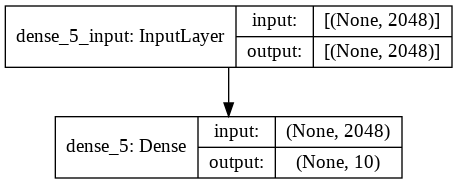

In [ ]:
multi_logistic_model = models.Sequential([
  Dense(10, activation='softmax', input_shape=(2048,))
])
multi_logistic_model.summary()

plot_model(multi_logistic_model, show_shapes=True)

In [ ]:
multi_logistic_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

multi_hist=multi_logistic_model.fit(train_features, train_y, epochs=20, batch_size=100, validation_split=0.10)

Epoch 1/20
450/450 [==============================] - 2s 4ms/step - loss: 1.3045 - accuracy: 0.5549 - val_loss: 1.1229 - val_accuracy: 0.6234
Epoch 2/20
450/450 [==============================] - 2s 4ms/step - loss: 1.0374 - accuracy: 0.6473 - val_loss: 1.0580 - val_accuracy: 0.6438
Epoch 3/20
450/450 [==============================] - 2s 4ms/step - loss: 0.9781 - accuracy: 0.6672 - val_loss: 1.0680 - val_accuracy: 0.6326
Epoch 4/20
450/450 [==============================] - 2s 4ms/step - loss: 0.9451 - accuracy: 0.6770 - val_loss: 1.0846 - val_accuracy: 0.6312
Epoch 5/20
450/450 [==============================] - 2s 4ms/step - loss: 0.9239 - accuracy: 0.6807 - val_loss: 1.0540 - val_accuracy: 0.6388
Epoch 6/20
450/450 [==============================] - 2s 4ms/step - loss: 0.9078 - accuracy: 0.6878 - val_loss: 1.0523 - val_accuracy: 0.6396
Epoch 7/20
450/450 [==============================] - 2s 4ms/step - loss: 0.8935 - accuracy: 0.6920 - val_loss: 1.0898 - val_accuracy: 0.6390
Epoch 

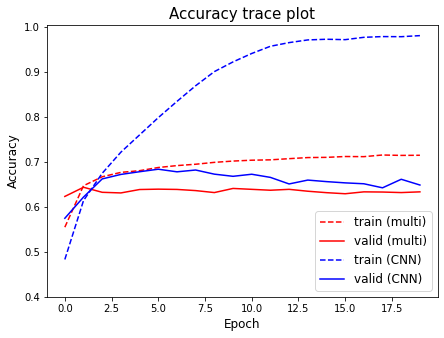

313/313 [==============================] - 1s 2ms/step - loss: 1.1212 - accuracy: 0.6398
Performance of multi logistic model
...test accuracy: 0.640, test loss: 1.121
Performance of CNN
...test accuracy: 0.636, test loss: 3.001


In [ ]:
plt.figure(figsize=(7,5))
plt.plot(multi_hist.history['accuracy'], 'r--', label='train (multi)')
plt.plot(multi_hist.history['val_accuracy'], 'r-', label='valid (multi)')
plt.plot(cnn_hist.history['accuracy'], 'b--', label='train (CNN)')
plt.plot(cnn_hist.history['val_accuracy'], 'b-', label='valid (CNN)')
plt.ylim([0.4, 1.005])
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.title('Accuracy trace plot', fontsize=15)
plt.show()

multi_sc = multi_logistic_model.evaluate(test_features, test_y)
print('Performance of multi logistic model')
print('...test accuracy: %.3f, test loss: %.3f'%(multi_sc[1], multi_sc[0]))
print('Performance of CNN')
print('...test accuracy: %.3f, test loss: %.3f'%(cnn_sc[1], cnn_sc[0]))
